In [7]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import pandas as pd
import numpy as np
import cv2
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import KFold
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
import optuna
import joblib
from sklearn.preprocessing import LabelEncoder
from torchvision.models import resnet50, ResNet50_Weights
from multiprocessing import Pool
import random
import pickle

In [8]:
# Directory to save best model and report

save_dir = os.path.join("/kaggle/working", datetime.now().strftime("%H-%M"))
image_cache_dir = os.path.join("/kaggle/working/cache/images")
# Ensure save_dir exists
os.makedirs(save_dir, exist_ok=True)
os.makedirs(image_cache_dir, exist_ok=True)

best_model_path = os.path.join(save_dir, "best_model.pth")
report_path = os.path.join(save_dir, "best_model_report.json")

In [9]:
def set_seed(seed: int):
    """Set manual seed for reproducibility."""
    random.seed(seed)                  # Python random generator
    np.random.seed(seed)               # NumPy random generator
    torch.manual_seed(seed)            # CPU
    torch.cuda.manual_seed(seed)       # GPU
    torch.cuda.manual_seed_all(seed)   # All GPUs
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior
    torch.backends.cudnn.benchmark = False      # Disable benchmark for reproducibility

# Set a seed for reproducibility
set_seed(42)

In [10]:
#Caculated in dataset
MEAN=[0.23887189, 0.5860071,  0.49763182]
STD=[0.18352188, 0.22406353, 0.22234197]

In [11]:
class CustomPreprocess:
    def __call__(self, img):
        clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(4, 4))

        #Needs efficient one
        # # Faster denoising
        # img = cv2.fastNlMeansDenoisingColored(img, h=3)
        
        # Histogram Equalization
        channels = cv2.split(img)
        equalized_channels = [clahe.apply(ch) for ch in channels]
        img = cv2.merge(equalized_channels)
        
        return img


In [12]:
class PaddyDiseaseDataset(Dataset):
    def __init__(self, metadata_file_path, image_directory, transform=None, image_cache_dir=None,use_cache=False):
        self.metadata = pd.read_csv(metadata_file_path)
        self.image_directory = image_directory
        self.transform = transform
        self.data = []
        self.labels = []
        self.image_cache_dir = image_cache_dir  # Default cache directory

        # Ensure image_cache_dir exists
        os.makedirs(self.image_cache_dir, exist_ok=True)

        # Initialize label encoder (no need to cache this based on your preference)
        unique_labels = self.metadata.iloc[:, 1].unique()
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(unique_labels)

        label_encoder_path = os.path.join(save_dir, "label_encoder.pkl")
        with open(label_encoder_path, "wb") as f:
            pickle.dump(self.label_encoder, f)

        # Load images, apply transformations, and cache
        for idx in tqdm(range(len(self.metadata)), desc="Loading and Caching Images"):
            img_name = self.metadata.iloc[idx, 0]
            cache_path = os.path.join(self.image_cache_dir, f"{img_name}.pt")  # Save as PyTorch tensor

            if use_cache and os.path.exists(cache_path):
                # Load cached image
                image = torch.load(cache_path)  # Load the tensor directly
            else:
                # Read, preprocess, and save image to cache
                image = cv2.imread(os.path.join(self.image_directory, img_name))
                if self.transform:
                    image = self.transform(image)

                if use_cache:
                    torch.save(image, cache_path)  # Save the tensor as a .pt file

            # Transform label
            label = self.label_encoder.transform([self.metadata.iloc[idx, 1]])[0]
            self.data.append(image)
            self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


In [13]:
transform = transforms.Compose([
    CustomPreprocess(),   
    transforms.ToPILImage(),  # Convert OpenCV image to PIL image
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),  # Convert to Tensor
    transforms.Normalize(mean=MEAN, std=STD)  # Normalize using computed mean and std
])

In [14]:
# Define paths
metadata_file_path = os.path.join("/", 'kaggle', 'input', 'paddy-disease-dataset', 'paddy-doctor-diseases-normal-all', 'metadata.csv')
image_directory = os.path.join("/", 'kaggle', 'input', 'paddy-disease-dataset', 'paddy-doctor-diseases-normal-all', 'images')

# Create dataset instance with transforms
dataset = PaddyDiseaseDataset(
    metadata_file_path,
    image_directory,
    transform=transform,
    image_cache_dir=image_cache_dir,
    use_cache=False
)

Loading and Caching Images: 100%|██████████| 16225/16225 [02:50<00:00, 95.36it/s] 


In [15]:
train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # Remaining 20% for testing
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4)


# Testing Dataloader

In [16]:
for images, labels in train_loader:
    print(images.shape)  # Should print the shape of the batch of images
    print(labels)        # Should print the batch of labels
    break  # Remove this break to iterate over the entire DataLoader

torch.Size([32, 3, 224, 224])
tensor([ 4,  0,  7,  9,  7,  8,  7, 10,  4, 11,  7,  7,  5,  0,  0,  9,  9,  4,
        10,  2,  4,  9,  4,  9,  5,  4, 12,  9,  4,  4,  1,  5])


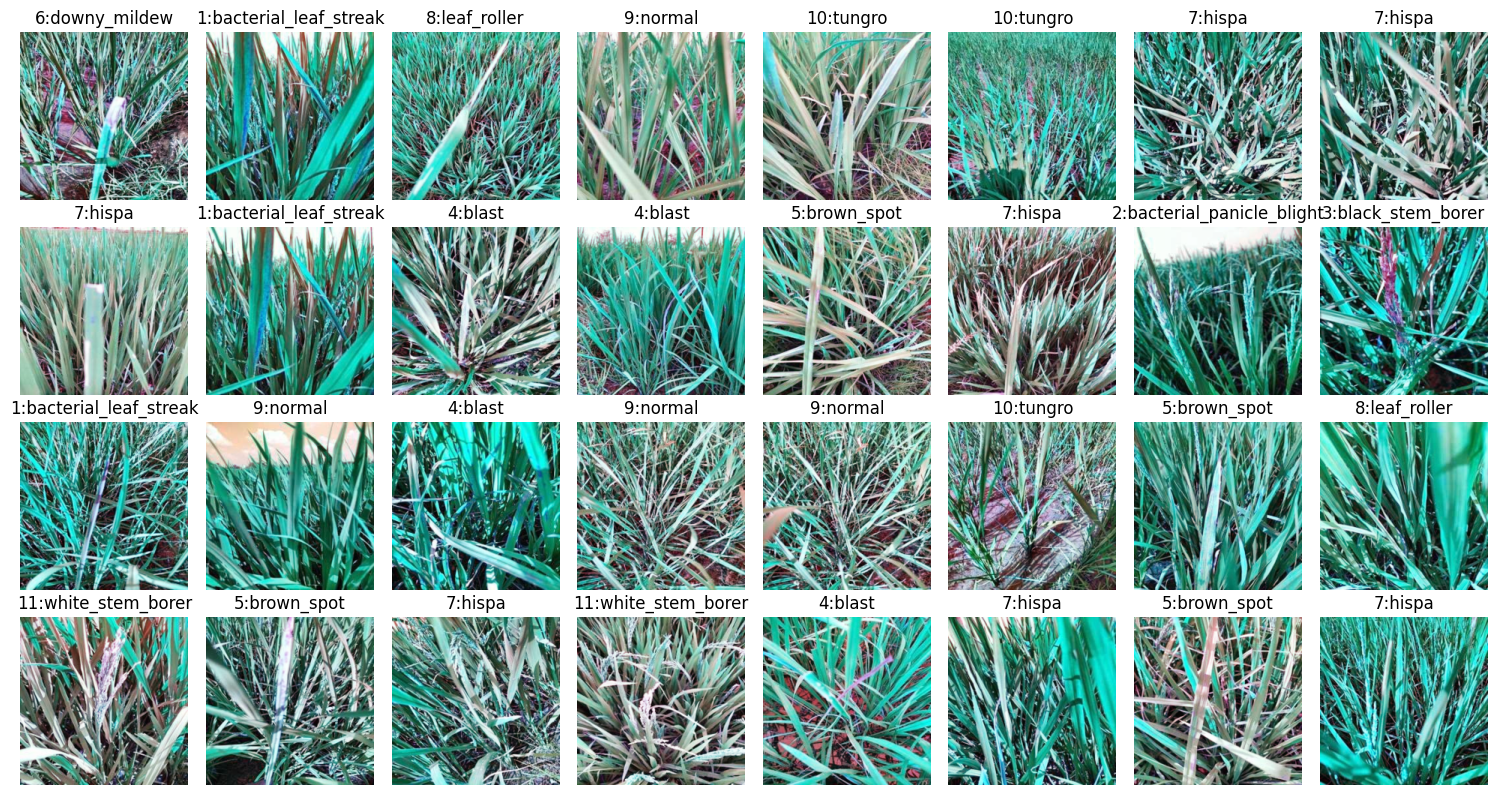

In [18]:
# Function to visualize an entire batch of images and labels
def visualize_data(dataloader, dataset, images_per_row=8):
    # Get a batch of images and labels
    images, labels = next(iter(dataloader))

    # Number of images in the batch
    num_samples = images.size(0)

    # Calculate number of rows needed
    num_rows = (num_samples + images_per_row - 1) // images_per_row  # Ceiling division for rows

    # Create a grid of images
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, 2 * num_rows))
    axes = axes.flatten()  # Flatten to easily index into the axes

    for i in range(num_samples):
        # Convert tensor image to numpy for visualization
        image = images[i].permute(1, 2, 0).numpy()  # Change from CxHxW to HxWxC
        image = image * STD + MEAN  # De-normalize the image
        image = np.clip(image, 0, 1)  # Clip to [0, 1] range

        axes[i].imshow(image)

        # Convert the numeric label back to string using label_name_mapping
        label_str = dataset.label_encoder.inverse_transform([labels[i].item()])[0]  
        axes[i].set_title(f"{labels[i]}:{label_str}")  # Access the string representation of the label
        axes[i].axis('off')
    
    # Hide any remaining empty subplots
    for j in range(num_samples, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Call the visualize function
visualize_data(train_loader,dataset)

# Training Model

In [19]:
def save_model_and_report(model, accuracy, precision, recall, f1, epoch):
    # Save the model state dictionary
    torch.save(model.state_dict(), best_model_path)
    
    # Create and save a report
    report = {
        "epoch": epoch + 1,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }
    
    with open(report_path, 'w') as f:
        print(f"Report Stored at: {report_path}")
        json.dump(report, f)
    print(f"New best model saved with F1 score: {f1:.4f}")

In [20]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [21]:
num_classes = len(dataset.label_encoder.classes_)  # Get the number of classes from your dataset
num_classes

13

In [22]:
def create_model(dropout_rate=0.5):
    # Load the pre-trained ResNet50 model
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

    # Add a Dropout layer before the final fully connected layer
    model.avgpool = nn.Sequential(
        model.avgpool,
        nn.Dropout(p=dropout_rate)  # Dropout layer with the given rate
    )

    # Replace the final fully connected layer to match the number of classes
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    
    # Move the model to the device (CPU or GPU)
    model.to(device)

    # Check if multiple GPUs are available
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs!")
        model = torch.nn.DataParallel(model)  # Use multiple GPUs if available
    
    return model

In [23]:
# Validation function with additional metrics
def validate_model(model, test_loader):
    model.eval()
    total = 0
    correct = 0
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    # Calculate metrics
    accuracy = 100 * correct / total
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    
    print(f'Validation Accuracy: {accuracy:.2f}%')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')
    
    return accuracy, precision, recall, f1


In [24]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs,best_f1,save_model):
    model.train()  # Set the model to training mode
    train_losses = []  # Store epoch losses
    train_accuracies = []  # Store epoch accuracies
    val_accuracies = []  # Store validation accuracies
    best_f1_fold=best_f1
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct, total = 0, 0
        
        # Training loop
        with tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False) as pbar:
            for images, labels in pbar:
                images, labels = images.to(device), labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                # Update progress bar with loss and accuracy
                pbar.set_postfix(loss=running_loss / (pbar.n + 1), accuracy=100 * correct / total)

        # Calculate epoch loss and accuracy
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        
        # Validation after each epoch
        val_accuracy, epoch_val_precision, epoch_val_recall, epoch_val_f1 = validate_model(model, val_loader)
        val_accuracies.append(val_accuracy)



        if(epoch_val_f1 > best_f1_fold):
            best_f1_fold = epoch_val_f1
            if(save_model):
                save_model_and_report(model,val_accuracy, epoch_val_precision, epoch_val_recall, epoch_val_f1,epoch)

            
        model.train()  # Set model back to training mode after validation
        
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%')
    
    return train_losses, train_accuracies, val_accuracies, best_f1_fold  


In [25]:
# Function to plot training/validation loss and accuracy
def plot_metrics(metric_data, metric_name, save_dir):
    plt.figure(figsize=(10, 5))
    for fold_idx, metrics in enumerate(metric_data, 1):
        plt.plot(range(1, len(metrics) + 1), metrics, label=f'Fold {fold_idx}')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} Across Epochs for Each Fold')
    plt.legend()
    
    # Save the plot
    plot_path = os.path.join(save_dir, f'{metric_name.replace(" ", "_").lower()}_plot.png')
    plt.savefig(plot_path)
    plt.show()

## Hyperparameter Tuning 

### Do it with subset of data as it runs in multiple epoch

In [26]:
batch_size=64
# Randomly sample a subset of the dataset
subset_size = int(len(dataset) * 0.2)  # Use 50% of the data for training
subset_indices = np.random.choice(len(dataset), size=subset_size, replace=False)

# Create a new sampler for the subset
subset_sampler = SubsetRandomSampler(subset_indices)

# Create DataLoader for the subset
train_loader_subset = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=subset_sampler)


In [27]:
def objective(trial):
    # Hyperparameters to tune
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)  # Use log scale for learning rate
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True)  # Use log scale for weight decay
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)  
    num_epochs = trial.suggest_int('num_epochs', 5, 10)  # Number of epochs to train for

    # Initialize model, optimizer, and loss function
    model = create_model(dropout_rate=dropout_rate)  # Pass dropout_rate if used in model
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

     # Print the hyperparameters for each trial
    print(f"\n\n----------------------Trial {trial.number+1} Hyperparameters: learning_rate={learning_rate}, batch_size={batch_size}, "
          f"weight_decay={weight_decay}, dropout_rate={dropout_rate}, num_epochs={num_epochs}----------------------\n\n")


    # Train the model and get the best F1 score
    _, _, _, best_f1_fold = train_model(
        model, 
        train_loader_subset, 
        test_loader, 
        criterion, 
        optimizer, 
        num_epochs,
        best_f1=0.0,
        save_model=False
    )
    
    return best_f1_fold  # This is the value Optuna will maximize (F1 score)

In [28]:
# Run the hyperparameter search
study = optuna.create_study(direction='maximize')  # We want to maximize F1 score
study.optimize(objective, n_trials=10)  # 10 trials for hyperparameter tuning


[I 2024-11-16 04:18:08,321] A new study created in memory with name: no-name-c09b9da8-8c32-42da-91c3-770fd4efade0
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 75.8MB/s]




----------------------Trial 1 Hyperparameters: learning_rate=0.00022595836126293708, batch_size=32, weight_decay=1.5636004758933116e-05, dropout_rate=0.28543945250599917, num_epochs=10----------------------




/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 58.43%
Precision: 0.64
Recall: 0.58
F1 Score: 0.54
Epoch [1/10], Loss: 1.9590, Training Accuracy: 36.27%, Validation Accuracy: 58.43%


Validation Accuracy: 79.04%
Precision: 0.81
Recall: 0.79
F1 Score: 0.79
Epoch [2/10], Loss: 0.8098, Training Accuracy: 74.85%, Validation Accuracy: 79.04%


Validation Accuracy: 84.22%
Precision: 0.84
Recall: 0.84
F1 Score: 0.84
Epoch [3/10], Loss: 0.2268, Training Accuracy: 93.96%, Validation Accuracy: 84.22%


Validation Accuracy: 85.95%
Precision: 0.86
Recall: 0.86
F1 Score: 0.86
Epoch [4/10], Loss: 0.0572, Training Accuracy: 98.92%, Validation Accuracy: 85.95%


Validation Accuracy: 85.55%
Precision: 0.86
Recall: 0.86
F1 Score: 0.86
Epoch [5/10], Loss: 0.0284, Training Accuracy: 99.57%, Validation Accuracy: 85.55%


Validation Accuracy: 86.59%
Precision: 0.87
Recall: 0.87
F1 Score: 0.87
Epoch [6/10], Loss: 0.0180, Training Accuracy: 99.72%, Validation Accuracy: 86.59%


Validation Accuracy: 87.09%
Precision: 0.87
Recall: 0.87
F1 Score: 0.87
Epoch [7/10], Loss: 0.0071, Training Accuracy: 99.94%, Validation Accuracy: 87.09%


Validation Accuracy: 86.13%
Precision: 0.86
Recall: 0.86
F1 Score: 0.86
Epoch [8/10], Loss: 0.0075, Training Accuracy: 99.88%, Validation Accuracy: 86.13%


Validation Accuracy: 84.90%
Precision: 0.85
Recall: 0.85
F1 Score: 0.85
Epoch [9/10], Loss: 0.0091, Training Accuracy: 99.85%, Validation Accuracy: 84.90%


[I 2024-11-16 04:22:19,405] Trial 0 finished with value: 0.8710794432633092 and parameters: {'learning_rate': 0.00022595836126293708, 'batch_size': 32, 'weight_decay': 1.5636004758933116e-05, 'dropout_rate': 0.28543945250599917, 'num_epochs': 10}. Best is trial 0 with value: 0.8710794432633092.


Validation Accuracy: 77.57%
Precision: 0.80
Recall: 0.78
F1 Score: 0.77
Epoch [10/10], Loss: 0.0794, Training Accuracy: 97.47%, Validation Accuracy: 77.57%


----------------------Trial 2 Hyperparameters: learning_rate=0.0004984071490345392, batch_size=16, weight_decay=7.154652618734619e-05, dropout_rate=0.44794799924480183, num_epochs=6----------------------




Validation Accuracy: 62.25%
Precision: 0.67
Recall: 0.62
F1 Score: 0.60
Epoch [1/6], Loss: 1.7513, Training Accuracy: 43.94%, Validation Accuracy: 62.25%


Validation Accuracy: 70.69%
Precision: 0.76
Recall: 0.71
F1 Score: 0.70
Epoch [2/6], Loss: 0.6602, Training Accuracy: 78.71%, Validation Accuracy: 70.69%


Validation Accuracy: 80.03%
Precision: 0.81
Recall: 0.80
F1 Score: 0.80
Epoch [3/6], Loss: 0.2994, Training Accuracy: 90.60%, Validation Accuracy: 80.03%


Validation Accuracy: 82.10%
Precision: 0.84
Recall: 0.82
F1 Score: 0.82
Epoch [4/6], Loss: 0.2071, Training Accuracy: 94.05%, Validation Accuracy: 82.10%


Validation Accuracy: 84.99%
Precision: 0.86
Recall: 0.85
F1 Score: 0.85
Epoch [5/6], Loss: 0.0986, Training Accuracy: 97.01%, Validation Accuracy: 84.99%


[I 2024-11-16 04:24:48,718] Trial 1 finished with value: 0.856151341993804 and parameters: {'learning_rate': 0.0004984071490345392, 'batch_size': 16, 'weight_decay': 7.154652618734619e-05, 'dropout_rate': 0.44794799924480183, 'num_epochs': 6}. Best is trial 0 with value: 0.8710794432633092.


Validation Accuracy: 85.61%
Precision: 0.86
Recall: 0.86
F1 Score: 0.86
Epoch [6/6], Loss: 0.1058, Training Accuracy: 96.95%, Validation Accuracy: 85.61%


----------------------Trial 3 Hyperparameters: learning_rate=0.00024648135719300076, batch_size=16, weight_decay=0.0009187288545559706, dropout_rate=0.07453842161338659, num_epochs=6----------------------




/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 62.47%
Precision: 0.64
Recall: 0.62
F1 Score: 0.58
Epoch [1/6], Loss: 1.8638, Training Accuracy: 40.59%, Validation Accuracy: 62.47%


Validation Accuracy: 80.92%
Precision: 0.82
Recall: 0.81
F1 Score: 0.81
Epoch [2/6], Loss: 0.7069, Training Accuracy: 79.60%, Validation Accuracy: 80.92%


Validation Accuracy: 83.05%
Precision: 0.84
Recall: 0.83
F1 Score: 0.83
Epoch [3/6], Loss: 0.1943, Training Accuracy: 94.88%, Validation Accuracy: 83.05%


Validation Accuracy: 84.44%
Precision: 0.85
Recall: 0.84
F1 Score: 0.84
Epoch [4/6], Loss: 0.0645, Training Accuracy: 98.61%, Validation Accuracy: 84.44%


Validation Accuracy: 84.28%
Precision: 0.85
Recall: 0.84
F1 Score: 0.84
Epoch [5/6], Loss: 0.0559, Training Accuracy: 98.83%, Validation Accuracy: 84.28%


[I 2024-11-16 04:27:18,221] Trial 2 finished with value: 0.8436278684482538 and parameters: {'learning_rate': 0.00024648135719300076, 'batch_size': 16, 'weight_decay': 0.0009187288545559706, 'dropout_rate': 0.07453842161338659, 'num_epochs': 6}. Best is trial 0 with value: 0.8710794432633092.


Validation Accuracy: 83.88%
Precision: 0.85
Recall: 0.84
F1 Score: 0.84
Epoch [6/6], Loss: 0.0622, Training Accuracy: 98.40%, Validation Accuracy: 83.88%


----------------------Trial 4 Hyperparameters: learning_rate=3.186717121109819e-05, batch_size=32, weight_decay=5.2091153955778464e-05, dropout_rate=0.3723614608174201, num_epochs=10----------------------




/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 27.73%
Precision: 0.25
Recall: 0.28
F1 Score: 0.20
Epoch [1/10], Loss: 2.4793, Training Accuracy: 16.55%, Validation Accuracy: 27.73%


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 34.95%
Precision: 0.40
Recall: 0.35
F1 Score: 0.26
Epoch [2/10], Loss: 2.1903, Training Accuracy: 33.37%, Validation Accuracy: 34.95%


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 42.00%
Precision: 0.49
Recall: 0.42
F1 Score: 0.35
Epoch [3/10], Loss: 1.8677, Training Accuracy: 44.81%, Validation Accuracy: 42.00%


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 52.27%
Precision: 0.56
Recall: 0.52
F1 Score: 0.46
Epoch [4/10], Loss: 1.5186, Training Accuracy: 55.78%, Validation Accuracy: 52.27%


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 59.01%
Precision: 0.64
Recall: 0.59
F1 Score: 0.54
Epoch [5/10], Loss: 1.1823, Training Accuracy: 65.82%, Validation Accuracy: 59.01%


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 63.61%
Precision: 0.66
Recall: 0.64
F1 Score: 0.60
Epoch [6/10], Loss: 0.8766, Training Accuracy: 75.69%, Validation Accuracy: 63.61%


Validation Accuracy: 68.23%
Precision: 0.72
Recall: 0.68
F1 Score: 0.66
Epoch [7/10], Loss: 0.6463, Training Accuracy: 83.76%, Validation Accuracy: 68.23%


Validation Accuracy: 72.97%
Precision: 0.75
Recall: 0.73
F1 Score: 0.72
Epoch [8/10], Loss: 0.4538, Training Accuracy: 91.19%, Validation Accuracy: 72.97%


Validation Accuracy: 75.53%
Precision: 0.76
Recall: 0.76
F1 Score: 0.75
Epoch [9/10], Loss: 0.2954, Training Accuracy: 95.13%, Validation Accuracy: 75.53%


[I 2024-11-16 04:31:26,355] Trial 3 finished with value: 0.7594108558408684 and parameters: {'learning_rate': 3.186717121109819e-05, 'batch_size': 32, 'weight_decay': 5.2091153955778464e-05, 'dropout_rate': 0.3723614608174201, 'num_epochs': 10}. Best is trial 0 with value: 0.8710794432633092.


Validation Accuracy: 76.21%
Precision: 0.76
Recall: 0.76
F1 Score: 0.76
Epoch [10/10], Loss: 0.1791, Training Accuracy: 97.97%, Validation Accuracy: 76.21%


----------------------Trial 5 Hyperparameters: learning_rate=3.270695624554314e-05, batch_size=16, weight_decay=3.9028793991608084e-05, dropout_rate=0.48701115157898045, num_epochs=5----------------------




/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 29.74%
Precision: 0.22
Recall: 0.30
F1 Score: 0.21
Epoch [1/5], Loss: 2.4809, Training Accuracy: 16.61%, Validation Accuracy: 29.74%


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 35.59%
Precision: 0.41
Recall: 0.36
F1 Score: 0.27
Epoch [2/5], Loss: 2.2074, Training Accuracy: 32.94%, Validation Accuracy: 35.59%


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 40.74%
Precision: 0.47
Recall: 0.41
F1 Score: 0.33
Epoch [3/5], Loss: 1.8868, Training Accuracy: 42.87%, Validation Accuracy: 40.74%


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 49.24%
Precision: 0.53
Recall: 0.49
F1 Score: 0.43
Epoch [4/5], Loss: 1.5626, Training Accuracy: 52.02%, Validation Accuracy: 49.24%


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-11-16 04:33:30,615] Trial 4 finished with value: 0.49990028140907594 and parameters: {'learning_rate': 3.270695624554314e-05, 'batch_size': 16, 'weight_decay': 3.9028793991608084e-05, 'dropout_rate': 0.48701115157898045, 'num_epochs': 5}. Best is trial 0 with value: 0.8710794432633092.


Validation Accuracy: 55.53%
Precision: 0.59
Recall: 0.56
F1 Score: 0.50
Epoch [5/5], Loss: 1.2395, Training Accuracy: 64.65%, Validation Accuracy: 55.53%


----------------------Trial 6 Hyperparameters: learning_rate=0.01898830625219712, batch_size=64, weight_decay=0.0004119257300913747, dropout_rate=0.16413097631241141, num_epochs=10----------------------




/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 16.12%
Precision: 0.08
Recall: 0.16
F1 Score: 0.10
Epoch [1/10], Loss: 3.1629, Training Accuracy: 15.01%, Validation Accuracy: 16.12%


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 12.67%
Precision: 0.05
Recall: 0.13
F1 Score: 0.05
Epoch [2/10], Loss: 3.4518, Training Accuracy: 14.98%, Validation Accuracy: 12.67%


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 14.55%
Precision: 0.03
Recall: 0.15
F1 Score: 0.05
Epoch [3/10], Loss: 2.6386, Training Accuracy: 15.07%, Validation Accuracy: 14.55%


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 7.80%
Precision: 0.01
Recall: 0.08
F1 Score: 0.01
Epoch [4/10], Loss: 2.4644, Training Accuracy: 17.13%, Validation Accuracy: 7.80%


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 17.04%
Precision: 0.06
Recall: 0.17
F1 Score: 0.07
Epoch [5/10], Loss: 2.3394, Training Accuracy: 21.88%, Validation Accuracy: 17.04%


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 18.52%
Precision: 0.16
Recall: 0.19
F1 Score: 0.10
Epoch [6/10], Loss: 2.2770, Training Accuracy: 24.13%, Validation Accuracy: 18.52%


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 3.11%
Precision: 0.17
Recall: 0.03
F1 Score: 0.01
Epoch [7/10], Loss: 2.2280, Training Accuracy: 24.93%, Validation Accuracy: 3.11%


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 18.15%
Precision: 0.24
Recall: 0.18
F1 Score: 0.12
Epoch [8/10], Loss: 2.1536, Training Accuracy: 27.92%, Validation Accuracy: 18.15%


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 23.20%
Precision: 0.26
Recall: 0.23
F1 Score: 0.17
Epoch [9/10], Loss: 2.1066, Training Accuracy: 29.92%, Validation Accuracy: 23.20%


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-11-16 04:37:36,443] Trial 5 finished with value: 0.16773987371472127 and parameters: {'learning_rate': 0.01898830625219712, 'batch_size': 64, 'weight_decay': 0.0004119257300913747, 'dropout_rate': 0.16413097631241141, 'num_epochs': 10}. Best is trial 0 with value: 0.8710794432633092.


Validation Accuracy: 22.84%
Precision: 0.17
Recall: 0.23
F1 Score: 0.16
Epoch [10/10], Loss: 2.0874, Training Accuracy: 30.69%, Validation Accuracy: 22.84%


----------------------Trial 7 Hyperparameters: learning_rate=0.009713635929779965, batch_size=16, weight_decay=1.3024133094650248e-05, dropout_rate=0.022955687448796724, num_epochs=8----------------------




/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 16.30%
Precision: 0.14
Recall: 0.16
F1 Score: 0.07
Epoch [1/8], Loss: 2.4749, Training Accuracy: 18.37%, Validation Accuracy: 16.30%


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 17.81%
Precision: 0.13
Recall: 0.18
F1 Score: 0.12
Epoch [2/8], Loss: 2.3328, Training Accuracy: 21.14%, Validation Accuracy: 17.81%


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 24.01%
Precision: 0.15
Recall: 0.24
F1 Score: 0.18
Epoch [3/8], Loss: 2.2552, Training Accuracy: 24.78%, Validation Accuracy: 24.01%


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 17.97%
Precision: 0.26
Recall: 0.18
F1 Score: 0.15
Epoch [4/8], Loss: 2.1669, Training Accuracy: 26.96%, Validation Accuracy: 17.97%


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 15.59%
Precision: 0.24
Recall: 0.16
F1 Score: 0.14
Epoch [5/8], Loss: 2.0361, Training Accuracy: 31.83%, Validation Accuracy: 15.59%


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 24.75%
Precision: 0.17
Recall: 0.25
F1 Score: 0.19
Epoch [6/8], Loss: 1.8781, Training Accuracy: 37.78%, Validation Accuracy: 24.75%


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 17.47%
Precision: 0.24
Recall: 0.17
F1 Score: 0.09
Epoch [7/8], Loss: 1.7759, Training Accuracy: 41.51%, Validation Accuracy: 17.47%


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-11-16 04:40:50,390] Trial 6 finished with value: 0.18772099557926983 and parameters: {'learning_rate': 0.009713635929779965, 'batch_size': 16, 'weight_decay': 1.3024133094650248e-05, 'dropout_rate': 0.022955687448796724, 'num_epochs': 8}. Best is trial 0 with value: 0.8710794432633092.


Validation Accuracy: 16.39%
Precision: 0.36
Recall: 0.16
F1 Score: 0.14
Epoch [8/8], Loss: 1.6911, Training Accuracy: 44.13%, Validation Accuracy: 16.39%


----------------------Trial 8 Hyperparameters: learning_rate=0.04379876932371848, batch_size=64, weight_decay=0.0006904764306596069, dropout_rate=0.29088830514153896, num_epochs=8----------------------




/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 14.70%
Precision: 0.06
Recall: 0.15
F1 Score: 0.06
Epoch [1/8], Loss: 6.5053, Training Accuracy: 15.35%, Validation Accuracy: 14.70%


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 15.44%
Precision: 0.02
Recall: 0.15
F1 Score: 0.04
Epoch [2/8], Loss: 4.1567, Training Accuracy: 14.76%, Validation Accuracy: 15.44%


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 18.95%
Precision: 0.15
Recall: 0.19
F1 Score: 0.13
Epoch [3/8], Loss: 3.1690, Training Accuracy: 16.67%, Validation Accuracy: 18.95%


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 16.18%
Precision: 0.06
Recall: 0.16
F1 Score: 0.07
Epoch [4/8], Loss: 2.7426, Training Accuracy: 18.09%, Validation Accuracy: 16.18%


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 7.86%
Precision: 0.03
Recall: 0.08
F1 Score: 0.03
Epoch [5/8], Loss: 2.6558, Training Accuracy: 17.32%, Validation Accuracy: 7.86%


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 15.96%
Precision: 0.08
Recall: 0.16
F1 Score: 0.10
Epoch [6/8], Loss: 2.4124, Training Accuracy: 20.18%, Validation Accuracy: 15.96%


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 13.53%
Precision: 0.05
Recall: 0.14
F1 Score: 0.05
Epoch [7/8], Loss: 2.3633, Training Accuracy: 19.35%, Validation Accuracy: 13.53%


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-11-16 04:44:04,296] Trial 7 finished with value: 0.13057779294193989 and parameters: {'learning_rate': 0.04379876932371848, 'batch_size': 64, 'weight_decay': 0.0006904764306596069, 'dropout_rate': 0.29088830514153896, 'num_epochs': 8}. Best is trial 0 with value: 0.8710794432633092.


Validation Accuracy: 9.46%
Precision: 0.09
Recall: 0.09
F1 Score: 0.05
Epoch [8/8], Loss: 2.3103, Training Accuracy: 21.73%, Validation Accuracy: 9.46%


----------------------Trial 9 Hyperparameters: learning_rate=1.734073417613521e-05, batch_size=64, weight_decay=0.00016325243078375187, dropout_rate=0.13913393656704764, num_epochs=7----------------------




/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 24.99%
Precision: 0.21
Recall: 0.25
F1 Score: 0.18
Epoch [1/7], Loss: 2.5160, Training Accuracy: 15.01%, Validation Accuracy: 24.99%


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 30.69%
Precision: 0.36
Recall: 0.31
F1 Score: 0.22
Epoch [2/7], Loss: 2.3236, Training Accuracy: 30.72%, Validation Accuracy: 30.69%


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 34.39%
Precision: 0.47
Recall: 0.34
F1 Score: 0.26
Epoch [3/7], Loss: 2.1006, Training Accuracy: 38.46%, Validation Accuracy: 34.39%


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 40.43%
Precision: 0.49
Recall: 0.40
F1 Score: 0.34
Epoch [4/7], Loss: 1.8602, Training Accuracy: 45.39%, Validation Accuracy: 40.43%


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 47.77%
Precision: 0.56
Recall: 0.48
F1 Score: 0.42
Epoch [5/7], Loss: 1.6139, Training Accuracy: 54.14%, Validation Accuracy: 47.77%


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 53.31%
Precision: 0.61
Recall: 0.53
F1 Score: 0.47
Epoch [6/7], Loss: 1.3593, Training Accuracy: 61.88%, Validation Accuracy: 53.31%


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-11-16 04:46:54,122] Trial 8 finished with value: 0.5222538876371291 and parameters: {'learning_rate': 1.734073417613521e-05, 'batch_size': 64, 'weight_decay': 0.00016325243078375187, 'dropout_rate': 0.13913393656704764, 'num_epochs': 7}. Best is trial 0 with value: 0.8710794432633092.


Validation Accuracy: 57.23%
Precision: 0.64
Recall: 0.57
F1 Score: 0.52
Epoch [7/7], Loss: 1.1185, Training Accuracy: 68.26%, Validation Accuracy: 57.23%


----------------------Trial 10 Hyperparameters: learning_rate=0.0615002306010423, batch_size=64, weight_decay=0.00011569156398644393, dropout_rate=0.01627036549226668, num_epochs=6----------------------




/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 15.65%
Precision: 0.05
Recall: 0.16
F1 Score: 0.06
Epoch [1/6], Loss: 5.8091, Training Accuracy: 15.32%, Validation Accuracy: 15.65%


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 9.31%
Precision: 0.02
Recall: 0.09
F1 Score: 0.03
Epoch [2/6], Loss: 3.4550, Training Accuracy: 15.29%, Validation Accuracy: 9.31%


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 15.69%
Precision: 0.05
Recall: 0.16
F1 Score: 0.06
Epoch [3/6], Loss: 2.7659, Training Accuracy: 14.82%, Validation Accuracy: 15.69%


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 13.25%
Precision: 0.22
Recall: 0.13
F1 Score: 0.06
Epoch [4/6], Loss: 2.6774, Training Accuracy: 18.34%, Validation Accuracy: 13.25%


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 8.60%
Precision: 0.01
Recall: 0.09
F1 Score: 0.02
Epoch [5/6], Loss: 2.6833, Training Accuracy: 19.11%, Validation Accuracy: 8.60%


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-11-16 04:49:19,522] Trial 9 finished with value: 0.061854374047965684 and parameters: {'learning_rate': 0.0615002306010423, 'batch_size': 64, 'weight_decay': 0.00011569156398644393, 'dropout_rate': 0.01627036549226668, 'num_epochs': 6}. Best is trial 0 with value: 0.8710794432633092.


Validation Accuracy: 14.27%
Precision: 0.02
Recall: 0.14
F1 Score: 0.04
Epoch [6/6], Loss: 2.4245, Training Accuracy: 21.51%, Validation Accuracy: 14.27%


In [29]:

# Store the best hyperparameters
report_data = {
    "best_hyperparameters": study.best_params,
    "best_f1_score": study.best_value
}

# Save the report
report_path = os.path.join(save_dir, "hyper_parameter_best_model_report.json")
with open(report_path, 'w') as f:
    json.dump(report_data, f, indent=4)

# Print the best hyperparameters and F1 score
print(f"Best hyperparameters: {study.best_params}")
print(f"Best F1 score: {study.best_value}")

Best hyperparameters: {'learning_rate': 0.00022595836126293708, 'batch_size': 32, 'weight_decay': 1.5636004758933116e-05, 'dropout_rate': 0.28543945250599917, 'num_epochs': 10}
Best F1 score: 0.8710794432633092


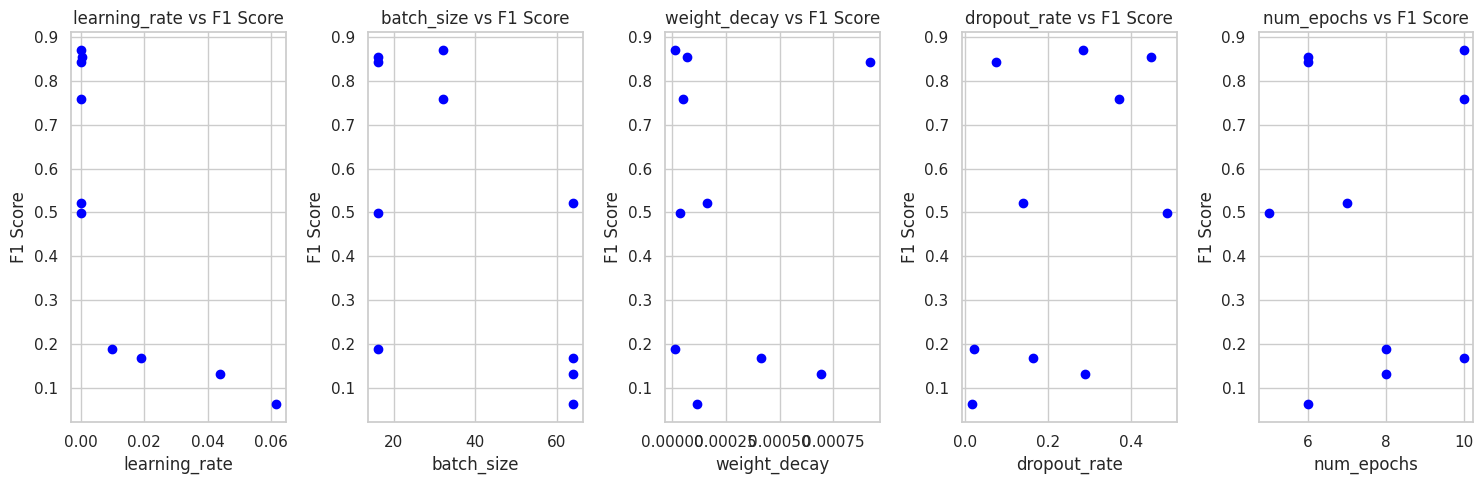

Graph saved at: /kaggle/working/04-15/fine_tuning_graphs/hyperparameter_vs_f1.png


In [30]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure the "fine_tuning_graphs" directory exists
fine_tuning_dir = os.path.join(save_dir, "fine_tuning_graphs")
os.makedirs(fine_tuning_dir, exist_ok=True)

# Extract hyperparameters and F1 scores
trials = study.trials
hyperparameters = []
f1_scores = []

for trial in trials:
    # Extract hyperparameters and the corresponding F1 score
    hyperparameters.append(trial.params)
    f1_scores.append(trial.value)

# Convert to DataFrame for easy plotting
df = pd.DataFrame(hyperparameters)
df['f1_score'] = f1_scores

# Create a pairplot or scatter plot for better visualization of relationships
sns.set(style="whitegrid")

# Plot the relationship of each hyperparameter with F1 score
fig, axes = plt.subplots(1, len(df.columns) - 1, figsize=(15, 5))
for i, column in enumerate(df.columns[:-1]):
    axes[i].scatter(df[column], df['f1_score'], color='blue', label=column)
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('F1 Score')
    axes[i].set_title(f'{column} vs F1 Score')

plt.tight_layout()

# Save the figure in the "fine_tuning_graphs" directory
graph_file_path = os.path.join(fine_tuning_dir, "hyperparameter_vs_f1.png")
plt.savefig(graph_file_path)

# Optionally, display the plot
plt.show()

# Print the saved file path
print(f"Graph saved at: {graph_file_path}")


## K fold valdiation

In [31]:
k_folds=3
num_epochs=10
learning_rate = 0.00022595836126293708
batch_size = 32
weight_decay = 1.5636004758933116e-05
dropout_rate=0.28543945250599917

In [32]:
kf = KFold(n_splits=k_folds, shuffle=True)
fold_train_losses,fold_train_accuracies, fold_val_accuracies = [], [], []

In [33]:
# Cross-validation loop with best F1 tracking
best_f1 = 0.0  # Initialize best F1 score across folds

Fold 1/3


Validation Accuracy: 87.24%
Precision: 0.88
Recall: 0.87
F1 Score: 0.87
Report Stored at: /kaggle/working/04-15/hyper_parameter_best_model_report.json
New best model saved with F1 score: 0.8710
Epoch [1/10], Loss: 1.0642, Training Accuracy: 66.12%, Validation Accuracy: 87.24%


Validation Accuracy: 92.01%
Precision: 0.92
Recall: 0.92
F1 Score: 0.92
Report Stored at: /kaggle/working/04-15/hyper_parameter_best_model_report.json
New best model saved with F1 score: 0.9196
Epoch [2/10], Loss: 0.2591, Training Accuracy: 92.15%, Validation Accuracy: 92.01%


Validation Accuracy: 93.68%
Precision: 0.94
Recall: 0.94
F1 Score: 0.94
Report Stored at: /kaggle/working/04-15/hyper_parameter_best_model_report.json
New best model saved with F1 score: 0.9367
Epoch [3/10], Loss: 0.1272, Training Accuracy: 96.34%, Validation Accuracy: 93.68%


Validation Accuracy: 93.09%
Precision: 0.93
Recall: 0.93
F1 Score: 0.93
Epoch [4/10], Loss: 0.0835, Training Accuracy: 97.60%, Validation Accuracy: 93.09%


Validation Accuracy: 93.60%
Precision: 0.94
Recall: 0.94
F1 Score: 0.94
Epoch [5/10], Loss: 0.0855, Training Accuracy: 97.29%, Validation Accuracy: 93.60%


Validation Accuracy: 94.27%
Precision: 0.94
Recall: 0.94
F1 Score: 0.94
Report Stored at: /kaggle/working/04-15/hyper_parameter_best_model_report.json
New best model saved with F1 score: 0.9426
Epoch [6/10], Loss: 0.0769, Training Accuracy: 97.68%, Validation Accuracy: 94.27%


Validation Accuracy: 94.18%
Precision: 0.94
Recall: 0.94
F1 Score: 0.94
Epoch [7/10], Loss: 0.0542, Training Accuracy: 98.33%, Validation Accuracy: 94.18%


Validation Accuracy: 94.18%
Precision: 0.94
Recall: 0.94
F1 Score: 0.94
Epoch [8/10], Loss: 0.0518, Training Accuracy: 98.44%, Validation Accuracy: 94.18%


Validation Accuracy: 94.36%
Precision: 0.94
Recall: 0.94
F1 Score: 0.94
Report Stored at: /kaggle/working/04-15/hyper_parameter_best_model_report.json
New best model saved with F1 score: 0.9435
Epoch [9/10], Loss: 0.0444, Training Accuracy: 98.59%, Validation Accuracy: 94.36%


Validation Accuracy: 95.06%
Precision: 0.95
Recall: 0.95
F1 Score: 0.95
Report Stored at: /kaggle/working/04-15/hyper_parameter_best_model_report.json
New best model saved with F1 score: 0.9506
Epoch [10/10], Loss: 0.0512, Training Accuracy: 98.38%, Validation Accuracy: 95.06%
Validation Accuracy: 95.06%
Precision: 0.95
Recall: 0.95
F1 Score: 0.95
Fold 2/3


Validation Accuracy: 85.45%
Precision: 0.86
Recall: 0.85
F1 Score: 0.85
Epoch [1/10], Loss: 1.1125, Training Accuracy: 64.20%, Validation Accuracy: 85.45%


Validation Accuracy: 91.51%
Precision: 0.92
Recall: 0.92
F1 Score: 0.91
Epoch [2/10], Loss: 0.2805, Training Accuracy: 91.58%, Validation Accuracy: 91.51%


Validation Accuracy: 92.66%
Precision: 0.93
Recall: 0.93
F1 Score: 0.93
Epoch [3/10], Loss: 0.1357, Training Accuracy: 95.90%, Validation Accuracy: 92.66%


Validation Accuracy: 92.59%
Precision: 0.93
Recall: 0.93
F1 Score: 0.93
Epoch [4/10], Loss: 0.1150, Training Accuracy: 96.73%, Validation Accuracy: 92.59%


Validation Accuracy: 92.64%
Precision: 0.93
Recall: 0.93
F1 Score: 0.93
Epoch [5/10], Loss: 0.0843, Training Accuracy: 97.41%, Validation Accuracy: 92.64%


Validation Accuracy: 92.18%
Precision: 0.93
Recall: 0.92
F1 Score: 0.92
Epoch [6/10], Loss: 0.0685, Training Accuracy: 97.93%, Validation Accuracy: 92.18%


Validation Accuracy: 94.51%
Precision: 0.95
Recall: 0.95
F1 Score: 0.94
Epoch [7/10], Loss: 0.0714, Training Accuracy: 97.95%, Validation Accuracy: 94.51%


Validation Accuracy: 93.03%
Precision: 0.93
Recall: 0.93
F1 Score: 0.93
Epoch [8/10], Loss: 0.0521, Training Accuracy: 98.61%, Validation Accuracy: 93.03%


Validation Accuracy: 93.82%
Precision: 0.94
Recall: 0.94
F1 Score: 0.94
Epoch [9/10], Loss: 0.0760, Training Accuracy: 97.83%, Validation Accuracy: 93.82%


Validation Accuracy: 92.90%
Precision: 0.93
Recall: 0.93
F1 Score: 0.93
Epoch [10/10], Loss: 0.0577, Training Accuracy: 98.34%, Validation Accuracy: 92.90%
Validation Accuracy: 92.90%
Precision: 0.93
Recall: 0.93
F1 Score: 0.93
Fold 3/3


Validation Accuracy: 88.26%
Precision: 0.89
Recall: 0.88
F1 Score: 0.88
Epoch [1/10], Loss: 1.0594, Training Accuracy: 66.72%, Validation Accuracy: 88.26%


Validation Accuracy: 91.01%
Precision: 0.91
Recall: 0.91
F1 Score: 0.91
Epoch [2/10], Loss: 0.2667, Training Accuracy: 92.11%, Validation Accuracy: 91.01%


Validation Accuracy: 91.77%
Precision: 0.92
Recall: 0.92
F1 Score: 0.92
Epoch [3/10], Loss: 0.1199, Training Accuracy: 96.51%, Validation Accuracy: 91.77%


Validation Accuracy: 94.32%
Precision: 0.94
Recall: 0.94
F1 Score: 0.94
Epoch [4/10], Loss: 0.1054, Training Accuracy: 97.17%, Validation Accuracy: 94.32%


Validation Accuracy: 92.90%
Precision: 0.93
Recall: 0.93
F1 Score: 0.93
Epoch [5/10], Loss: 0.0898, Training Accuracy: 97.47%, Validation Accuracy: 92.90%


Validation Accuracy: 92.90%
Precision: 0.93
Recall: 0.93
F1 Score: 0.93
Epoch [6/10], Loss: 0.0898, Training Accuracy: 97.37%, Validation Accuracy: 92.90%


Validation Accuracy: 93.38%
Precision: 0.94
Recall: 0.93
F1 Score: 0.93
Epoch [7/10], Loss: 0.0797, Training Accuracy: 97.69%, Validation Accuracy: 93.38%


Validation Accuracy: 94.67%
Precision: 0.95
Recall: 0.95
F1 Score: 0.95
Epoch [8/10], Loss: 0.0518, Training Accuracy: 98.46%, Validation Accuracy: 94.67%


Validation Accuracy: 92.97%
Precision: 0.93
Recall: 0.93
F1 Score: 0.93
Epoch [9/10], Loss: 0.0623, Training Accuracy: 98.11%, Validation Accuracy: 92.97%


Validation Accuracy: 93.42%
Precision: 0.94
Recall: 0.93
F1 Score: 0.93
Epoch [10/10], Loss: 0.0596, Training Accuracy: 98.14%, Validation Accuracy: 93.42%
Validation Accuracy: 93.42%
Precision: 0.94
Recall: 0.93
F1 Score: 0.93


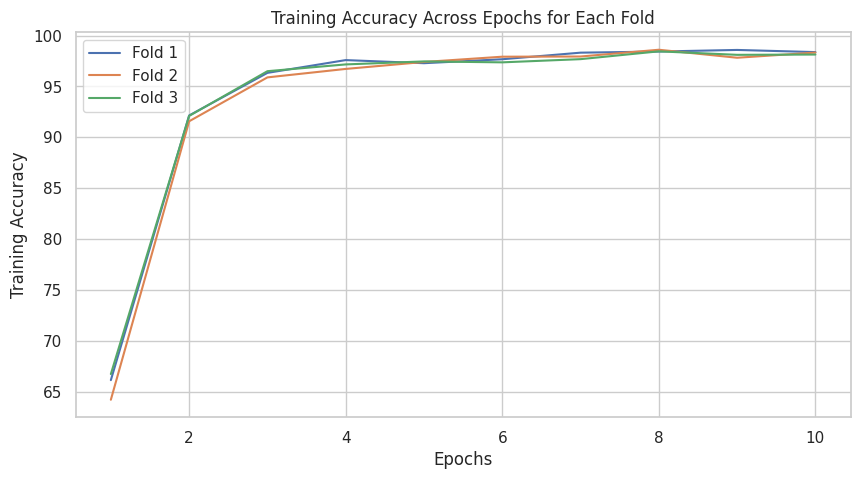

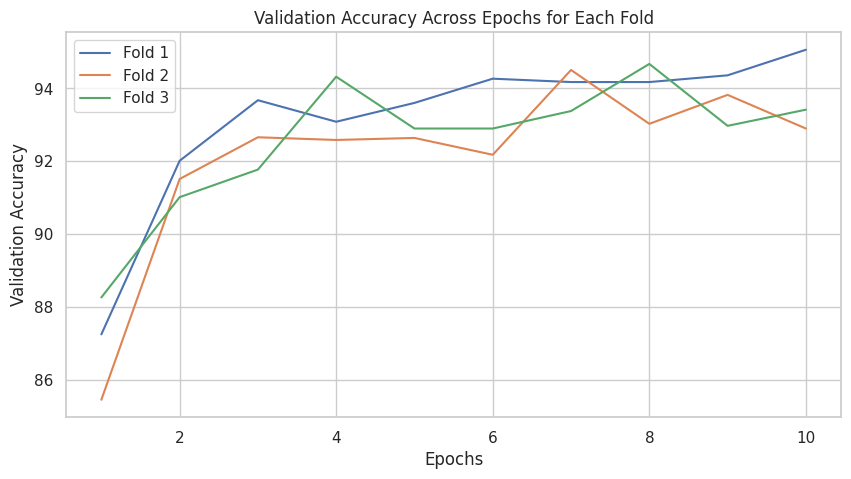

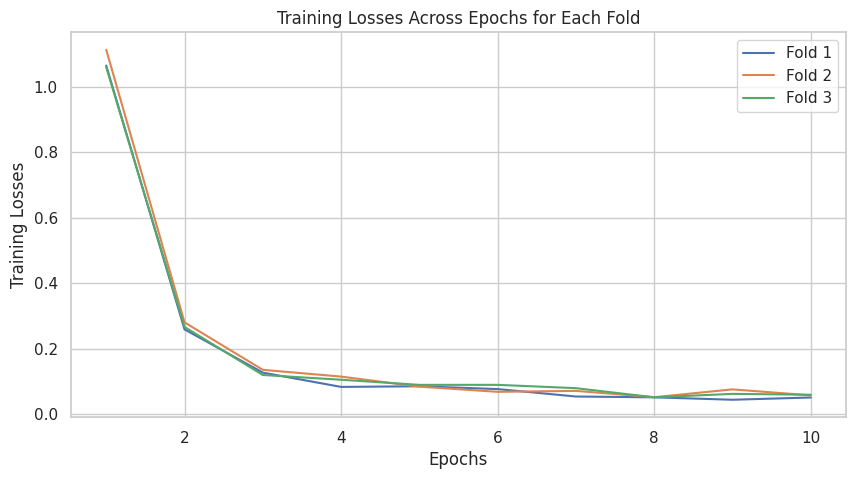

In [34]:
for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
    print(f"Fold {fold + 1}/{k_folds}")
    
    # Prepare DataLoaders
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_subsampler)
    val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=val_subsampler)
    
    # Model, criterion, and optimizer
    model = create_model(dropout_rate=dropout_rate)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Train and validate
    train_losses, train_accuracies, val_accuracies, best_f1_fold = train_model(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        num_epochs,
        best_f1,
        save_model=True)
    
    accuracy, precision, recall, f1 = validate_model(model, val_loader)

    # Set the best_f1
    best_f1 = max(best_f1, best_f1_fold)
    
    # Store metrics
    fold_train_losses.append(train_losses)
    fold_train_accuracies.append(train_accuracies)
    fold_val_accuracies.append(val_accuracies)


# After cross-validation loop, plot the results
plot_metrics(fold_train_accuracies, "Training Accuracy", save_dir)
plot_metrics(fold_val_accuracies, "Validation Accuracy", save_dir)
plot_metrics(fold_train_losses, "Training Losses", save_dir)

# Testing 


In [36]:
test_save_dir= os.path.join("/kaggle/working/04-15")
# Load the best model
model=create_model()
best_model_path = os.path.join(test_save_dir,'best_model.pth')  # Replace with the actual path to the best model
model.load_state_dict(torch.load(best_model_path,weights_only=True))
model.eval()  # Set the model to evaluation mode

# Validate on the test set
accuracy, precision, recall, f1 = validate_model(model, test_loader)

# Generate the classification report (optional: you can also use sklearn's classification_report)
report = f"""
Validation Accuracy: {accuracy:.2f}%
Precision: {precision:.2f}
Recall: {recall:.2f}
F1 Score: {f1:.2f}
"""

# Save the report to a file
report_path = os.path.join(test_save_dir,'classification_report_test.txt')
with open(report_path, 'w') as f:
    f.write(report)

print(f"Classification report saved to {report_path}")

Validation Accuracy: 98.40%
Precision: 0.98
Recall: 0.98
F1 Score: 0.98
Classification report saved to /kaggle/working/04-15/classification_report_test.txt


In [37]:
# import shutil
# shutil.make_archive('/kaggle/working/04-15', 'zip', '/kaggle/working/')

'/kaggle/working/04-15.zip'

In [38]:
# %cd /kaggle/working
# from IPython.display import FileLink
# FileLink('04-15.zip')


/kaggle/working


/kaggle/working/04-15.zip